## Import library

In [1]:
import csv
import datetime
import matplotlib.pyplot as plt
import numpy as np
import os
import requests
from datetime import datetime, timedelta
import pandas as pd
import seaborn as sns
import sklearn.metrics
import tensorflow as tf

from numpy import mean
from numpy import std
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras import activations
from tensorflow.keras import layers

2024-10-17 15:28:23.524286: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-17 15:28:23.525127: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-17 15:28:23.527552: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-17 15:28:23.534238: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:476] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1729139303.545403   15651 cuda_dnn.cc:8312] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1729139303.54

## Constants

In [2]:
BATCH_SIZE = 64
MELTING_TEMPERATURE = 2
MIN_SNOW_CM = 0.5 # Above this value, we consider it as snow
NUM_EPOCHS = 20
OUTPUT_DATASET_FILE = "snow_dataset.csv"
TFL_MODEL_FILE = "snow_forecast_model.tflite"
TFL_MODEL_HEADER_FILE = "snow_forecast_model.h"
TF_MODEL = "snow_forecast"

## Importing weather data

In [3]:
import pandas as pd

# Load the data from the CSV file
file_path = 'weatherHistory.csv' 
data = pd.read_csv(file_path) 
# Display the first few rows of the data
data.head(1)

,Formatted Date,Summary,Precip Type,Temperature (C),Apparent Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Loud Cover,Pressure (millibars),Daily Summary
0,2006-04-01 00:00:00.000 +0200,Partly Cloudy,rain,9.472222,7.388889,0.89,14.1197,251.0,15.8263,0.0,1015.13,Partly cloudy throughout the day.


## Data prepocessing

In [4]:
# Select columns we are using
my_data = data[['Temperature (C)', 'Humidity', 'Precip Type']]
# Deal with empty rows
my_data.loc[:, 'Precip Type'] = my_data['Precip Type'].fillna('other')
# Check if still have empty elements
my_data.isnull().sum()

Temperature (C)    0
Humidity           0
Precip Type        0
dtype: int64

In [5]:
# Encode the predictions
my_data.loc[:, 'Precip Type'] = my_data['Precip Type'].apply(lambda x: '1' if x == 'snow' else '0')
my_data.head(3)

,Temperature (C),Humidity,Precip Type
0,9.472222,0.89,0
1,9.355556,0.86,0
2,9.377778,0.89,0


In [6]:
# Type converting to float (64-bit double-precision float)
t_list = my_data['Temperature (C)'].astype(float).to_list()
h_list = my_data['Humidity'].astype(float).to_list()
s_list = my_data['Precip Type'].astype(float).to_list()

/tmp/ipykernel_15651/3638826313.py:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cm = plt.cm.get_cmap('gray_r')


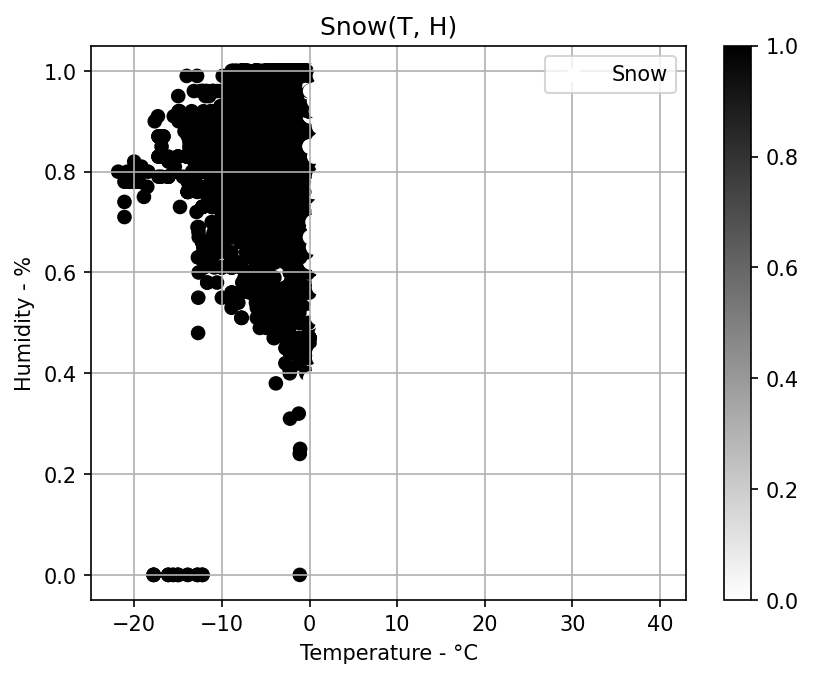

In [7]:
cm = plt.cm.get_cmap('gray_r')
plt.figure(dpi=150)
sc = plt.scatter(t_list, h_list, c=s_list, cmap=cm, label="Snow")
plt.colorbar(sc)
plt.legend()
plt.grid(True)
plt.title("Snow(T, H)")
plt.xlabel("Temperature - °C")
plt.ylabel("Humidity - %")
plt.show()

In [8]:
def gen_label(snow, temperature):
  if snow > MIN_SNOW_CM and temperature < MELTING_TEMPERATURE:
    return "Yes"
  else:
    return "No"

snow_labels = [gen_label(snow, temp) for snow, temp in zip(s_list, t_list)]

In [9]:
csv_header = ["Temp0", "Temp1", "Temp2", "Humi0", "Humi1", "Humi2", "Snow"]
# Create test samples and guarantee Temp2 Humi2 matchs Snow lable
df_dataset = pd.DataFrame(list(zip(t_list[:-2], t_list[1:-1], t_list[2:], h_list[:-2], h_list[1:-1], h_list[2:], snow_labels[2:])), columns = csv_header)

In [10]:
df0 = df_dataset[df_dataset['Snow'] == "No"]
df1 = df_dataset[df_dataset['Snow'] == "Yes"]

num_nosnow_samples_old = round((len(df0.index) / (len(df_dataset.index))) * 100, 2)
num_snow_samples_old   = round((len(df1.index) / (len(df_dataset.index))) * 100, 2)

# Random subsampling of the majority class to guarantee 50% split
if len(df1.index) < len(df0.index):
  df0_sub = df0.sample(len(df1.index))
  df_dataset = pd.concat([df0_sub, df1])
else:
  df1_sub = df1.sample(len(df0.index))
  df_dataset = pd.concat([df1_sub, df0])

df0 = df_dataset[df_dataset['Snow'] == "No"]
df1 = df_dataset[df_dataset['Snow'] == "Yes"]

num_nosnow_samples_new = round((len(df0.index) / (len(df_dataset.index))) * 100, 2)
num_snow_samples_new = round((len(df1.index) / (len(df_dataset.index))) * 100, 2)

# Show number of samples
df_samples_results = pd.DataFrame.from_records(
                [["% No Snow", num_nosnow_samples_old, num_nosnow_samples_new],
                ["% Snow", num_snow_samples_old, num_snow_samples_new]],
            columns = ["Class", "Before - %", "After - %"], index="Class").round(2)

display(df_samples_results)


,Before - %,After - %
Class,,
% No Snow,88.89,50.0
% Snow,11.11,50.0


### Scale the input features with Z-score independently

In [11]:
# Get all values
t_list = df_dataset['Temp0'].tolist()
h_list = df_dataset['Humi0'].tolist()
t_list = t_list + df_dataset['Temp2'].tail(2).tolist()
h_list = h_list + df_dataset['Humi2'].tail(2).tolist()

# Calculate mean and standard deviation
t_avg = mean(t_list)
h_avg = mean(h_list)
t_std = std(t_list)
h_std = std(h_list)
print("Temperature - [MEAN, STD]  ", round(t_avg, 5), round(t_std, 5))
print("Humidity - [MEAN, STD]     ", round(h_avg, 5), round(h_std, 5))

# Scaling with Z-score function
def scaling(val, avg, std):
  return (val - avg) / (std)

df_dataset['Temp0'] = df_dataset['Temp0'].apply(lambda x: scaling(x, t_avg, t_std))
df_dataset['Temp1'] = df_dataset['Temp1'].apply(lambda x: scaling(x, t_avg, t_std))
df_dataset['Temp2'] = df_dataset['Temp2'].apply(lambda x: scaling(x, t_avg, t_std))
df_dataset['Humi0'] = df_dataset['Humi0'].apply(lambda x: scaling(x, h_avg, h_std))
df_dataset['Humi1'] = df_dataset['Humi1'].apply(lambda x: scaling(x, h_avg, h_std))
df_dataset['Humi2'] = df_dataset['Humi2'].apply(lambda x: scaling(x, h_avg, h_std))

Temperature - [MEAN, STD]   5.4491 10.55251
Humidity - [MEAN, STD]      0.78737 0.17604


/tmp/ipykernel_15651/2381868132.py:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(t_list, ax=ax[0])
/tmp/ipykernel_15651/2381868132.py:10: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(h_list, ax=ax[1])
/tmp/ipykernel_15651/2381868132.py:15: UserWarning: 

`distplot` is a deprecated function a

Text(0.5, 1.0, 'Normalized humidity')

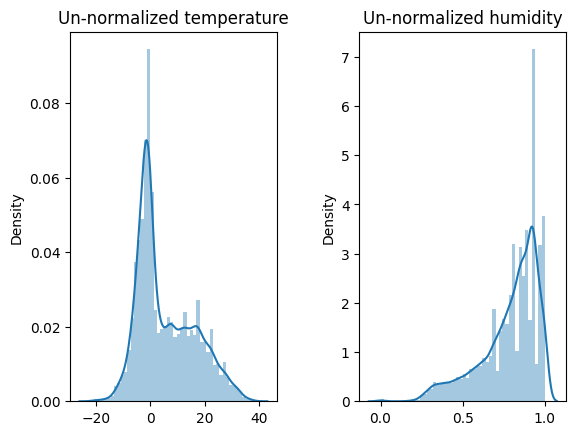

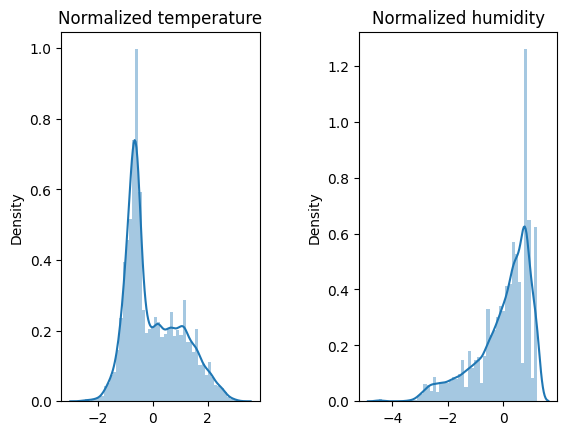

In [12]:
t_norm_list = df_dataset['Temp0'].tolist()
h_norm_list = df_dataset['Humi0'].tolist()
t_norm_list = t_norm_list + df_dataset['Temp2'].tail(2).tolist()
h_norm_list = h_norm_list + df_dataset['Humi2'].tail(2).tolist()

fig, ax=plt.subplots(1,2)
plt.subplots_adjust(wspace = 0.4)
sns.distplot(t_list, ax=ax[0])
ax[0].set_title("Un-normalized temperature")
sns.distplot(h_list, ax=ax[1])
ax[1].set_title("Un-normalized humidity")

fig, ax=plt.subplots(1,2)
plt.subplots_adjust(wspace = 0.5)
sns.distplot(t_norm_list, ax=ax[0])
ax[0].set_title("Normalized temperature")
sns.distplot(h_norm_list, ax=ax[1])
ax[1].set_title("Normalized humidity")

# Training the ML model with TF

In [13]:
f_names = df_dataset.columns.values[0:6]
l_name  = df_dataset.columns.values[6:7]
x = df_dataset[f_names]
y = df_dataset[l_name]

In [14]:
labelencoder = LabelEncoder()
labelencoder.fit(y.Snow)
y_encoded = labelencoder.transform(y.Snow)

In [15]:
# Split 1 (85% vs 15%)
x_train, x_validate_test, y_train, y_validate_test = train_test_split(x, y_encoded, test_size=0.15, random_state = 1)
# Split 2 (50% vs 50%)
x_test, x_validate, y_test, y_validate = train_test_split(x_validate_test, y_validate_test, test_size=0.50, random_state = 3)

In [16]:
model = tf.keras.Sequential()
model.add(layers.Dense(12, activation='relu', input_shape=(len(f_names),)))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(1, activation='sigmoid'))
model.summary()

/home/niko/.local/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2024-10-17 15:29:04.039990: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 12)             │            84 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 12)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            13 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 97 (388.00 B)

 Trainable params: 97 (388.00 B)

 Non-trainable params: 0 (0.00 B)

In [17]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [18]:
history = model.fit(x_train, y_train, epochs=NUM_EPOCHS, batch_size=BATCH_SIZE, validation_data=(x_validate, y_validate))     

AttributeError: module 'ml_dtypes' has no attribute 'float8_e3m4'
Epoch 1/20
285/285 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6507 - loss: 0.5789 - val_accuracy: 0.9154 - val_loss: 0.2548
Epoch 2/20
285/285 ━━━━━━━━━━━━━━━━━━━━ 0s 657us/step - accuracy: 0.9147 - loss: 0.2395 - val_accuracy: 0.9484 - val_loss: 0.1512
Epoch 3/20
285/285 ━━━━━━━━━━━━━━━━━━━━ 0s 672us/step - accuracy: 0.9434 - loss: 0.1634 - val_accuracy: 0.9602 - val_loss: 0.1113
Epoch 4/20
285/285 ━━━━━━━━━━━━━━━━━━━━ 0s 691us/step - accuracy: 0.9541 - loss: 0.1313 - val_accuracy: 0.9658 - val_loss: 0.0876
Epoch 5/20
285/285 ━━━━━━━━━━━━━━━━━━━━ 0s 638us/step - accuracy: 0.9619 - loss: 0.1093 - val_accuracy: 0.9720 - val_loss: 0.0764
Epoch 6/20
285/285 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step - accuracy: 0.9688 - loss: 0.0944 - val_accuracy: 0.9745 - val_loss: 0.0690
Epoch 7/20
285/285 ━━━━━━━━━━━━━━━━━━━━ 0s 674us/step - accuracy: 0.9725 - loss: 0.0841 - val_accuracy: 0.9764 - val_loss: 0.0629
Epoch 8/20
285/285 ━━━━━━━

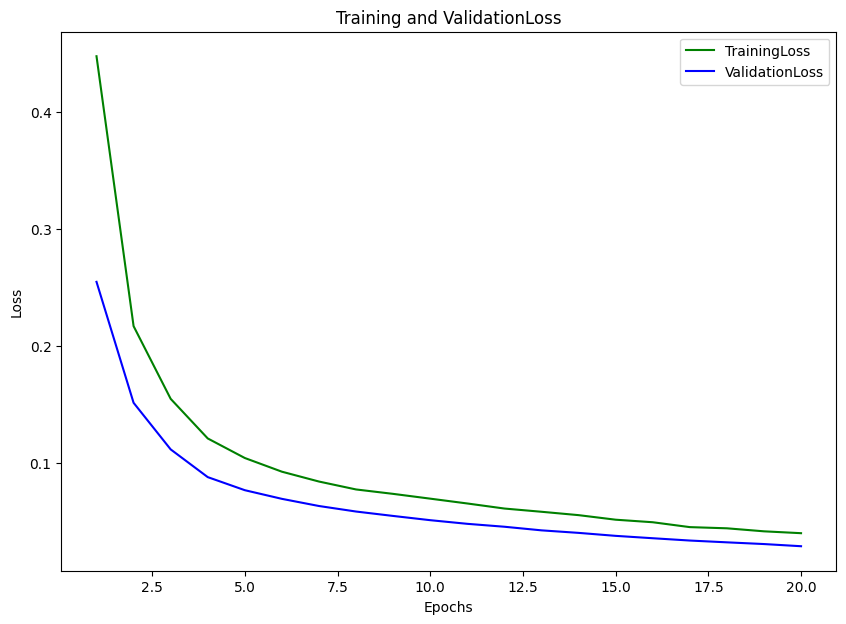

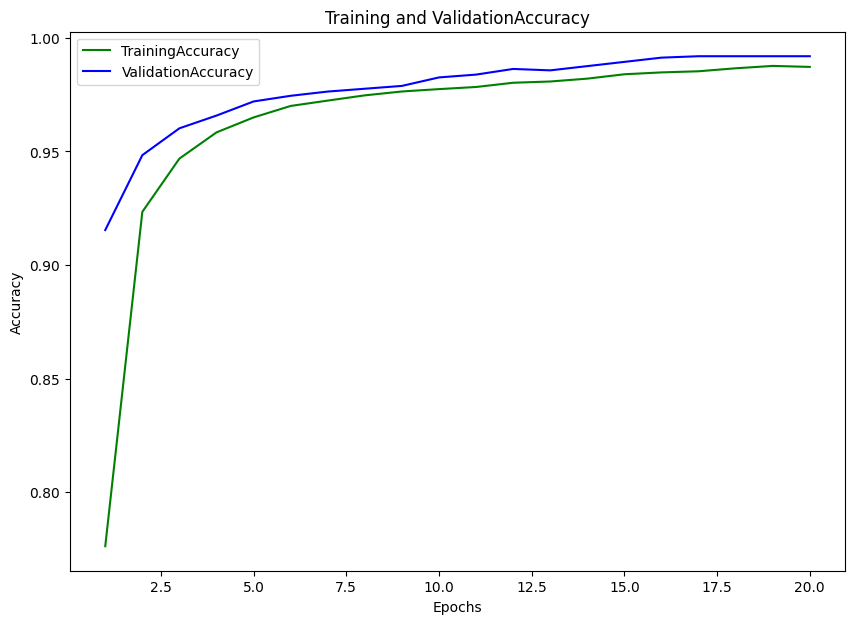

In [19]:
loss_train = history.history['loss']
loss_val   = history.history['val_loss']
acc_train  = history.history['accuracy']
acc_val    = history.history['val_accuracy']
epochs     = range(1, NUM_EPOCHS + 1)

def plot_train_val_history(x, y_train, y_val, type_txt):
  plt.figure(figsize = (10,7))
  plt.plot(x, y_train, 'g', label='Training'+type_txt)
  plt.plot(x, y_val, 'b', label='Validation'+type_txt)
  plt.title('Training and Validation'+type_txt)
  plt.xlabel('Epochs')
  plt.ylabel(type_txt)
  plt.legend()
  plt.show()

plot_train_val_history(epochs, loss_train, loss_val, "Loss")
plot_train_val_history(epochs, acc_train, acc_val, "Accuracy")
     

In [20]:
model.save('Model/model.h5')

# Evaluating the model effectiveness

51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 704us/step


<Figure size 1000x700 with 0 Axes>

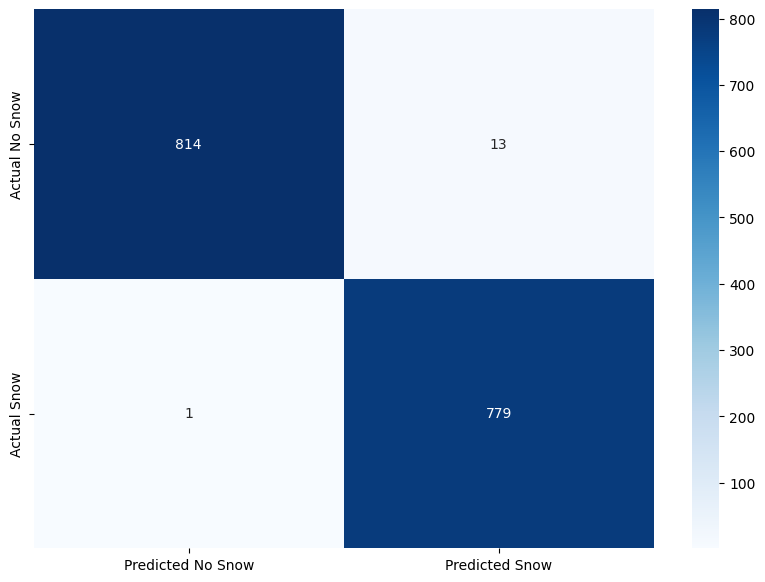

<Figure size 1000x700 with 0 Axes>

In [21]:
y_test_pred = model.predict(x_test)

y_test_pred = (y_test_pred > 0.5).astype("int32")

cm = sklearn.metrics.confusion_matrix(y_test, y_test_pred)

index_names  = ["Actual No Snow", "Actual Snow"]
column_names = ["Predicted No Snow", "Predicted Snow"]

df_cm = pd.DataFrame(cm, index = index_names, columns = column_names)

plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True, fmt='d', cmap="Blues")
plt.figure(figsize = (10,7))
     

In [22]:
TN = cm[0][0]
TP = cm[1][1]
FN = cm[1][0]
FP = cm[0][1]

accuracy = (TP + TN) / (TP + TN + FN + FP)
precision = TP / (TP + FP)
recall = TP / (TP + FN)
f_score = (2 * recall * precision) / (recall + precision)

print("Accuracy:  ", round(accuracy, 3))
print("Recall:    ", round(recall, 3))
print("Precision: ", round(precision, 3))
print("F-score:   ", round(f_score, 3))

Accuracy:   0.991
Recall:     0.999
Precision:  0.984
F-score:    0.991


## Quantizing the model with TFLite converter

In [23]:
def representative_data_gen():
  for i_value in tf.data.Dataset.from_tensor_slices(x_test).batch(1).take(100):
    i_value_f32 = tf.dtypes.cast(i_value, tf.float32)
    yield [i_value_f32]
     

In [26]:
model = tf.keras.models.load_model('Model/model.h5')

In [27]:
model.export('Model/tfmodel')

INFO:tensorflow:Assets written to: Model/tfmodel/assets


INFO:tensorflow:Assets written to: Model/tfmodel/assets


Saved artifact at 'Model/tfmodel'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 6), dtype=tf.float32, name='input_layer')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  124124558542624: TensorSpec(shape=(), dtype=tf.resource, name=None)
  124124558547552: TensorSpec(shape=(), dtype=tf.resource, name=None)
  124124558630528: TensorSpec(shape=(), dtype=tf.resource, name=None)
  124124558628592: TensorSpec(shape=(), dtype=tf.resource, name=None)


In [28]:
converter = tf.lite.TFLiteConverter.from_saved_model('Model/tfmodel')

In [29]:
converter.representative_dataset = tf.lite.RepresentativeDataset(representative_data_gen)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.int8
converter.inference_output_type = tf.int8
     

In [30]:
tflite_model_quant = converter.convert()
open(TFL_MODEL_FILE, "wb").write(tflite_model_quant)

W0000 00:00:1729139450.462985   15651 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1729139450.463022   15651 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.
2024-10-17 15:30:50.463305: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: Model/tfmodel
2024-10-17 15:30:50.463679: I tensorflow/cc/saved_model/reader.cc:52] Reading meta graph with tags { serve }
2024-10-17 15:30:50.463686: I tensorflow/cc/saved_model/reader.cc:147] Reading SavedModel debug info (if present) from: Model/tfmodel
I0000 00:00:1729139450.465661   15651 mlir_graph_optimization_pass.cc:401] MLIR V1 optimization pass is not enabled
2024-10-17 15:30:50.466114: I tensorflow/cc/saved_model/loader.cc:236] Restoring SavedModel bundle.
2024-10-17 15:30:50.483455: I tensorflow/cc/saved_model/loader.cc:220] Running initialization op on SavedModel bundle at path: Model/tfmodel
2024-10-17 15:30:50.488087: I tensorflow/cc/saved_model/loader.cc:466] SavedModel load for 

2400

In [31]:
!apt-get update && apt-get -qq install xxd
!xxd -i snow_forecast_model.tflite > model.h
!cat model.h

Reading package lists... Done
E: Could not open lock file /var/lib/apt/lists/lock - open (13: Permission denied)
E: Unable to lock directory /var/lib/apt/lists/
W: Problem unlinking the file /var/cache/apt/pkgcache.bin - RemoveCaches (13: Permission denied)
W: Problem unlinking the file /var/cache/apt/srcpkgcache.bin - RemoveCaches (13: Permission denied)
unsigned char snow_forecast_model_tflite[] = {
  0x1c, 0x00, 0x00, 0x00, 0x54, 0x46, 0x4c, 0x33, 0x14, 0x00, 0x20, 0x00,
  0x1c, 0x00, 0x18, 0x00, 0x14, 0x00, 0x10, 0x00, 0x0c, 0x00, 0x00, 0x00,
  0x08, 0x00, 0x04, 0x00, 0x14, 0x00, 0x00, 0x00, 0x1c, 0x00, 0x00, 0x00,
  0x88, 0x00, 0x00, 0x00, 0x08, 0x01, 0x00, 0x00, 0xc0, 0x02, 0x00, 0x00,
  0xd0, 0x02, 0x00, 0x00, 0xf4, 0x08, 0x00, 0x00, 0x03, 0x00, 0x00, 0x00,
  0x01, 0x00, 0x00, 0x00, 0x04, 0x00, 0x00, 0x00, 0xf6, 0xfc, 0xff, 0xff,
  0x0c, 0x00, 0x00, 0x00, 0x1c, 0x00, 0x00, 0x00, 0x3c, 0x00, 0x00, 0x00,
  0x0f, 0x00, 0x00, 0x00, 0x73, 0x65, 0x72, 0x76, 0x69, 0x6e, 0x67, 0x5f,
  0